# Tutoriel Hail 0.2

Inès Krissaane


https://hail.is/docs/devel/tutorials/01-genome-wide-association-study.html#Check-for-tutorial-data-or-download-if-necessary

In [1]:
import hail as hl
import hail.expr.aggregators as agg
hl.init()

Running on Apache Spark version 2.2.1
SparkUI available at http://10.142.0.8:4044
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version devel-aa83f2a1d041
NOTE: This is a beta version. Interfaces may change
  during the beta period. We recommend pulling
  the latest changes weekly.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import Counter
from math import log, isnan
from pprint import pprint
%matplotlib inline
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook, push_notebook, show

In [3]:
#vds.write("gs://1k-genome/1000-genomes/vds/ALL.chr.integrated_phase1_v3.20101123.snps_indels_svs.genotypes.vds")

In [4]:
#vds = hl.genetics.ReferenceGenome.read("gs://1k-genome/1000-genomes/vds/ALL.chr19.integrated_phase1_v3.20101123.snps_indels_svs.genotypes.vds")

# Getting to know our data

### Import VDS file 

In [4]:
vds = hl.import_vcf('gs://1k-genome/1kg.vcf.bgz')

2018-06-21 00:06:07 Hail: INFO: Coerced sorted dataset


In [17]:
vds.count()

(10961, 284)

In [6]:
list(vds.row)

['locus', 'alleles', 'rsid', 'qual', 'filters', 'info']

In [7]:
vds.rows().select().show(5)

+---------------+------------+
| locus         | alleles    |
+---------------+------------+
| locus<GRCh37> | array<str> |
+---------------+------------+
| 1:904165      | ["G","A"]  |
| 1:909917      | ["G","A"]  |
| 1:986963      | ["C","T"]  |
| 1:1563691     | ["T","G"]  |
| 1:1707740     | ["T","G"]  |
+---------------+------------+
showing top 5 rows



In [8]:
vds.rows().show(5)

+---------------+------------+------+-------------+----------+--------------+
| locus         | alleles    | rsid |        qual | filters  | info.AC      |
+---------------+------------+------+-------------+----------+--------------+
| locus<GRCh37> | array<str> | str  |     float64 | set<str> | array<int32> |
+---------------+------------+------+-------------+----------+--------------+
| 1:904165      | ["G","A"]  | NA   | 5.23464e+04 | null     | [518]        |
| 1:909917      | ["G","A"]  | NA   | 1.57694e+03 | null     | [18]         |
| 1:986963      | ["C","T"]  | NA   | 3.98060e+02 | null     | [5]          |
| 1:1563691     | ["T","G"]  | NA   | 1.09075e+03 | null     | [64]         |
| 1:1707740     | ["T","G"]  | NA   | 9.35178e+04 | null     | [997]        |
+---------------+------------+------+-------------+----------+--------------+

+----------------+---------+-------------------+----------------------+---------+
| info.AF        | info.AN | info.BaseQRankSum | info.Clipp

In [9]:
vds.s.show(5)

+---------+
| s       |
+---------+
| str     |
+---------+
| HG00096 |
| HG00099 |
| HG00105 |
| HG00118 |
| HG00129 |
+---------+
showing top 5 rows



In [18]:
list(vds.entry)

['GT', 'AD', 'DP', 'GQ', 'PL']

In [10]:
vds.entry.take(5)

[Struct(GT=0/0, AD=[4, 0], DP=4, GQ=12, PL=[0, 12, 147]),
 Struct(GT=0/0, AD=[8, 0], DP=8, GQ=24, PL=[0, 24, 315]),
 Struct(GT=0/0, AD=[8, 0], DP=8, GQ=23, PL=[0, 23, 230]),
 Struct(GT=0/0, AD=[7, 0], DP=7, GQ=21, PL=[0, 21, 270]),
 Struct(GT=0/0, AD=[5, 0], DP=5, GQ=15, PL=[0, 15, 205])]

In [11]:
vds.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str 
----------------------------------------
Row fields:
    'locus': locus<GRCh37> 
    'alleles': array<str> 
    'rsid': str 
    'qual': float64 
    'filters': set<str> 
    'info': struct {
        AC: array<int32>, 
        AF: array<float64>, 
        AN: int32, 
        BaseQRankSum: float64, 
        ClippingRankSum: float64, 
        DP: int32, 
        DS: bool, 
        FS: float64, 
        HaplotypeScore: float64, 
        InbreedingCoeff: float64, 
        MLEAC: array<int32>, 
        MLEAF: array<float64>, 
        MQ: float64, 
        MQ0: int32, 
        MQRankSum: float64, 
        QD: float64, 
        ReadPosRankSum: float64, 
        set: str
    } 
----------------------------------------
Entry fields:
    'GT': call 
    'AD': array<int32> 
    'DP': int32 
    'GQ': int32 
    'PL': array<int32> 
---------------------------------

In [12]:
print(vds.col.dtype)

struct{s: str}


# Adding column fields

In [6]:
table = (hl.import_table('gs://1k-genome/1kg_annotations.txt', impute=True)
         .key_by('Sample'))

2018-06-21 00:07:19 Hail: INFO: Reading table to impute column types
2018-06-21 00:07:20 Hail: INFO: Finished type imputation
  Loading column 'Sample' as type 'str' (imputed)
  Loading column 'Population' as type 'str' (imputed)
  Loading column 'SuperPopulation' as type 'str' (imputed)
  Loading column 'isFemale' as type 'bool' (imputed)
  Loading column 'PurpleHair' as type 'bool' (imputed)
  Loading column 'CaffeineConsumption' as type 'float64' (imputed)


In [20]:
table.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    'Sample': str 
    'Population': str 
    'SuperPopulation': str 
    'isFemale': bool 
    'PurpleHair': bool 
    'CaffeineConsumption': float64 
----------------------------------------
Key: ['Sample']
----------------------------------------


In [21]:
table.show(width=100)

+---------+------------+-----------------+----------+------------+---------------------+
| Sample  | Population | SuperPopulation | isFemale | PurpleHair | CaffeineConsumption |
+---------+------------+-----------------+----------+------------+---------------------+
| str     | str        | str             | bool     | bool       |             float64 |
+---------+------------+-----------------+----------+------------+---------------------+
| HG00096 | GBR        | EUR             | false    | false      |         7.70000e+01 |
| HG00097 | GBR        | EUR             | true     | true       |         6.70000e+01 |
| HG00098 | GBR        | EUR             | false    | false      |         8.30000e+01 |
| HG00099 | GBR        | EUR             | true     | false      |         6.40000e+01 |
| HG00100 | GBR        | EUR             | true     | false      |         5.90000e+01 |
| HG00101 | GBR        | EUR             | false    | true       |         7.70000e+01 |
| HG00102 | GBR      

In [ ]:
print(vds.col.dtype)

In [7]:
vds = vds.annotate_cols(**table[vds.s])

In [ ]:
print(vds.col.dtype)

In [ ]:
print(vds.col.dtype.pretty())

# Query functions and the Hail Expression Language

In [ ]:
pprint(table.aggregate(agg.counter(table.SuperPopulation)))

In [ ]:
pprint(table.aggregate(agg.stats(table.CaffeineConsumption)))

In [ ]:
table.count()

In [ ]:
vds.count_cols()

In [8]:
vds.aggregate_cols(agg.counter(vds.SuperPopulation))

{'AFR': 76, 'EAS': 72, 'AMR': 34, 'SAS': 55, 'EUR': 47}

In [ ]:
pprint(vds.aggregate_cols(agg.stats(vds.CaffeineConsumption)))

In [ ]:
snp_counts = vds.aggregate_rows(agg.counter(hl.Struct(ref=vds.alleles[0], alt=vds.alleles[1])))
pprint(snp_counts)

In [ ]:
from collections import Counter
counts = Counter(snp_counts)
counts.most_common()

In [9]:
dp_hist = vds.aggregate_entries(agg.hist(vds.DP, 0, 30, 30))

In [10]:
p = figure(title='DP Histogram', background_fill_color='#EEEEEE')

p.quad(bottom=0, top=dp_hist.bin_freq,
       left=dp_hist.bin_edges[:-1], right=dp_hist.bin_edges[1:],
       legend = 'DP', line_color='black')
output_notebook()


Loading BokehJS ...

In [11]:
show(p)

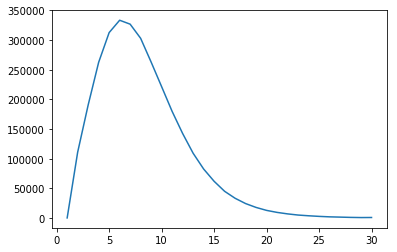

In [12]:
plt.plot(dp_hist.bin_edges[1:31], dp_hist.bin_freq);

# Quality Control

In [ ]:
vds.col.describe()

In [13]:
vds = hl.sample_qc(vds)

In [ ]:
vds.col.describe()

In [ ]:
df = vds.cols().to_pandas()

In [ ]:
df.head()

In [ ]:
def hist(data, bins=50):
    freqs, edges = np.histogram(data, density=True, bins=bins)
    return {'bottom': 0, 'top': freqs, 'left': edges[:-1], 'right': edges[1:], 'line_color': 'black'}

In [ ]:
p = figure(x_axis_label='Call Rate', y_axis_label='Frequency')
p.quad(**hist(df['sample_qc.call_rate']))
show(p)

In [ ]:
p = figure(x_axis_label='Mean Sample GQ', y_axis_label='Frequency')
p.quad(**hist(df['sample_qc.gq_mean']))

show(p)

In [ ]:
p = figure(x_axis_label='Mean DP', y_axis_label='Call Rate')
p.scatter(df["sample_qc.dp_mean"], df["sample_qc.call_rate"],
            alpha=0.5)
show(p)

In [ ]:
from bokeh.models import Span
from bokeh.layouts import gridplot
from bokeh.palettes import Viridis3

In [ ]:
p = figure(x_axis_label='Mean DP', y_axis_label='Call Rate')
p.scatter(df["sample_qc.dp_mean"], df["sample_qc.call_rate"],
            alpha=0.5)
p.renderers.extend([
    Span(location=0.97, dimension='width', line_color='black', line_width=1),
    Span(location=4, dimension='height', line_color='black', line_width=1)])
show(p)

In [14]:
vds = vds.filter_cols((vds.sample_qc.dp_mean >= 4) & (vds.sample_qc.call_rate >= 0.97))
print('After filter, %d/284 samples remain.' % vds.count_cols())

After filter, 250/284 samples remain.


In [ ]:
call_rate = vds.aggregate_entries(agg.fraction(hl.is_defined(vds.GT)))
print('pre QC call rate is %.3f' % call_rate)

In [15]:
ab = vds.AD[1] / hl.sum(vds.AD)

filter_condition_ab = ((vds.GT.is_hom_ref() & (ab <= 0.1)) |
                        (vds.GT.is_het() & (ab >= 0.25) & (ab <= 0.75)) |
                        (vds.GT.is_hom_var() & (ab >= 0.9)))

ds = vds.filter_entries(filter_condition_ab)

In [ ]:
post_qc_call_rate = vds.aggregate_entries(agg.fraction(hl.is_defined(vds.GT)))
print('post QC call rate is %.3f' % post_qc_call_rate)

In [ ]:
vds.row.describe()

In [16]:
vds = hl.variant_qc(ds).cache()

In [ ]:
vds.row.describe()

In [ ]:
variant_df = vds.rows().to_pandas()

p1 = figure(x_axis_label='Variant Mean GQ',
            y_axis_label='Frequency')
p1.quad(**hist(variant_df["variant_qc.gq_mean"]))

p2 = figure(x_axis_label='Alternate Allele Frequency',
            y_axis_label='Frequency')
p2.quad(**hist(variant_df["variant_qc.AF"]))

p3 = figure(x_axis_label='Variant Call Rate',
            y_axis_label='Frequency')
p3.quad(**hist(variant_df['variant_qc.call_rate']))

p4 = figure(x_axis_label='Hardy-Weinberg Equilibrium p-value',
            y_axis_label='Frequency')
p4.quad(**hist(variant_df['variant_qc.p_hwe']))

grid = gridplot([[p1, p2], [p3, p4]], plot_width=400, plot_height=400)
show(grid)

# Let’s do a GWAS!

In [17]:
common_ds = vds.filter_rows(vds.variant_qc.AF > 0.01)

In [18]:
print('Samples: %d  Variants: %d' % (common_ds.count_cols(), common_ds.count_rows()))

Samples: 250  Variants: 9177


In [19]:
gwas = hl.linear_regression(y=common_ds.CaffeineConsumption, x=common_ds.GT.n_alt_alleles())
gwas.row.describe()

2018-06-21 00:11:35 Hail: INFO: linear_regression: running on 250 samples for 1 response variable y,
    with input variable x, intercept, and 0 additional covariates...


--------------------------------------------------------
Type:
    struct {
        locus: locus<GRCh37>, 
        alleles: array<str>, 
        rsid: str, 
        qual: float64, 
        filters: set<str>, 
        info: struct {
            AC: array<int32>, 
            AF: array<float64>, 
            AN: int32, 
            BaseQRankSum: float64, 
            ClippingRankSum: float64, 
            DP: int32, 
            DS: bool, 
            FS: float64, 
            HaplotypeScore: float64, 
            InbreedingCoeff: float64, 
            MLEAC: array<int32>, 
            MLEAF: array<float64>, 
            MQ: float64, 
            MQ0: int32, 
            MQRankSum: float64, 
            QD: float64, 
            ReadPosRankSum: float64, 
            set: str
        }, 
        variant_qc: struct {
            call_rate: float64, 
            AC: int32, 
            AF: float64, 
            n_called: int32, 
            n_not_called: int32, 
            n_hom_ref: int32

In [32]:
len(common_ds.GT.n_alt_alleles().collect())

2294250

In [20]:
def qqplot(pvals):
    spvals = sorted(filter(lambda x: x and not(isnan(x)), pvals))
    exp = [-log(float(i) / len(spvals), 10) for i in np.arange(1, len(spvals) + 1, 1)]
    obs = [-log(p, 10) for p in spvals]
    p = figure(title='Q-Q Plot',
               x_axis_label='Expected p-value (-log10 scale)',
               y_axis_label='Observed p-value (-log10 scale)')
    p.scatter(x=exp, y=obs, color='black')
    bound = max(max(exp), max(obs)) * 1.1
    p.line([0, bound], [0, bound], color='red')
    show(p)

In [39]:
# Collect result of the linear regression
p_value = gwas.linreg.p_value.collect()
beta = gwas.linreg.beta.collect()
t_stat = gwas.linreg.t_stat.collect()
standard_error = gwas.linreg.standard_error.collect()

In [43]:
# Put the result in a DataFrame
d = {'p_value': p_value, 'beta': beta, 't_stat' : t_stat, 'standard_error' : standard_error}
df = pd.DataFrame(data=d)

In [45]:
df.describe()

,p_value,beta,t_stat,standard_error
count,9169.000000,9177.000000,9169.000000,9169.000000
mean,0.468054,-0.020660,-0.043056,0.533018
std,0.293545,0.931046,1.098078,0.268130
min,0.000034,-5.158402,-4.225417,0.322682
25%,0.208023,-0.382734,-0.789879,0.401331
50%,0.455461,-0.017422,-0.038704,0.443788
75%,0.720416,0.341271,0.704119,0.546200
max,0.999837,22.755556,4.080970,4.678042


In [47]:
df.standard_error.mean()

0.5330178417279204

In [48]:
import scipy.stats

In [ ]:
from google.cloud import storage
storage.Client()
client = storage.Client()
bucket = client.get_bucket('python-ines') #name of the bucket
blob = bucket.blob('result.csv') #name of the file
res.to_csv('result-csv', encoding='utf-8', index=False)  #write a csv in the local directory
blob.upload_from_filename('result-csv') 

In [21]:
qqplot(gwas.linreg.p_value.collect())

# Confounded!

In [ ]:
pca_eigenvalues, pca_scores, _ = hl.hwe_normalized_pca(common_ds.GT)

In [ ]:
pprint(pca_eigenvalues)

In [ ]:
pca_table = (
    pca_scores.select(SuperPopulation=common_ds.cols()[pca_scores.s].SuperPopulation,
                      PC1=pca_scores.scores[0],
                      PC2=pca_scores.scores[1])).to_pandas()

p = figure(title='PCA', background_fill_color='#EEEEEE',
          x_axis_label='PC1', y_axis_label='PC2')
pop_colors = {'AFR': 'green', 'EAS': 'black', 'EUR': 'blue', 'SAS': 'cyan', 'AMR': 'red'}

for pop, color in pop_colors.items():
    samples = pca_table[pca_table['SuperPopulation'] == pop]
    p.scatter(samples["PC1"], samples["PC2"],
              color=color,
              alpha=0.5,
              legend=pop,
              size=8)

p.legend.click_policy="hide"
show(p)

In [ ]:
cds = common_ds.annotate_cols(pca = pca_scores[common_ds.s])

linear_regression_results = hl.linear_regression(
    y=cds.CaffeineConsumption, x=cds.GT.n_alt_alleles(),
    covariates=[cds.isFemale, cds.pca.scores[0], cds.pca.scores[1], cds.pca.scores[2]])

pvals = linear_regression_results.linreg.p_value.collect()

In [ ]:
qqplot(pvals)

In [ ]:
def plDosage(pl):
    linear_scaled = pl.map(lambda x: 10 ** (-x / 10))
    pl_sum = hl.sum(linear_scaled)
    normed = linear_scaled / pl_sum
    return 1 * normed[1] + 2 * normed[2]

In [ ]:
linear_regression_results = hl.linear_regression(
    y=cds.CaffeineConsumption, x=plDosage(cds.PL),
    covariates=[cds.isFemale, cds.pca.scores[0], cds.pca.scores[1], cds.pca.scores[2]])

pvals = linear_regression_results.linreg.p_value.collect()

In [ ]:
qqplot(pvals)

# Rare variant analysis

In [ ]:
entries = vds.entries()
results = (entries.group_by(pop = entries.SuperPopulation, chromosome = entries.locus.contig)
      .aggregate(n_het = agg.count_where(entries.GT.is_het())))


In [ ]:
results.show()

In [ ]:
entries = entries.annotate(maf_bin = hl.cond(entries.info.AF[0]<0.01, "< 1%",
                             hl.cond(entries.info.AF[0]<0.05, "1%-5%", ">5%")))

results2 = (entries.group_by(af_bin = entries.maf_bin, purple_hair = entries.PurpleHair)
      .aggregate(mean_gq = agg.stats(entries.GQ).mean,
                 mean_dp = agg.stats(entries.DP).mean))

In [ ]:
results2.show()